<a href="https://colab.research.google.com/github/chillMLguy/ML24-25L/blob/main/prd13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Praca domowa nr 13




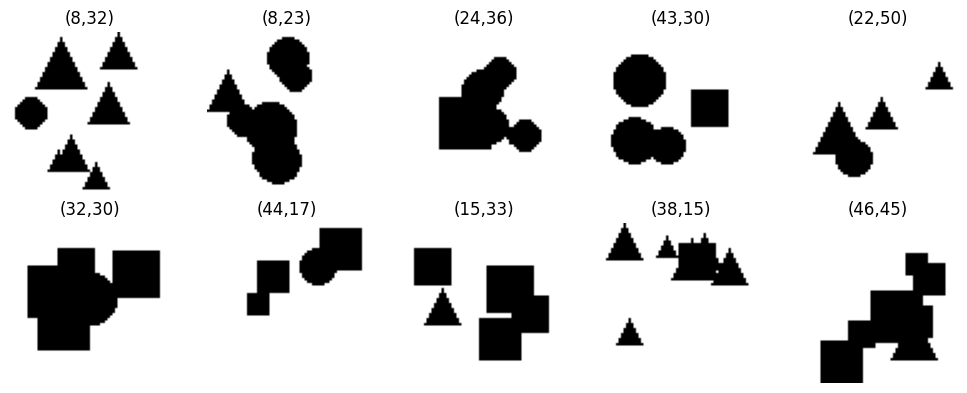

In [90]:
import torch, random, math, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  #podczas treningu kod wyświetlał pytorchowe ostrzeżenia, które tylko zaśmiecały przestrzeń

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#zmienne


SEED = 10
random.seed(SEED)
EPOCHS = 100
TOTAL_SAMPLES = 25000
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
STEPS=TOTAL_SAMPLES//BATCH_SIZE

#siatka na środki figur
GRID_SIDE = 12
KERNEL_SIZE = 20
STRIDE = 4

_centers_1d = torch.arange(GRID_SIDE) * STRIDE + (KERNEL_SIZE - 1) / 2
YY, XX = torch.meshgrid(_centers_1d, _centers_1d, indexing="ij")
CENTER_COORDS = torch.stack([XX.flatten(), YY.flatten()], dim=1).to(DEVICE)




#kod z zajęć, gdzieniegdzie zmodyfikowany przez wyskakujące błędy, ale sens jest ten sam czyli : ładowanie datasetu, displayowanie go oraz 2-wymiarowego sinusoidalnego kodowania pozycyjnego.
IMAGE = 64
SHAPES = ("circle", "square", "triangle")

def draw_shape(drawer, shape_type, center_x, center_y, radius):
    if shape_type == "circle":
        drawer.ellipse(
            [center_x - radius, center_y - radius, center_x + radius, center_y + radius],
            fill="black",
        )
    elif shape_type == "square":
        drawer.rectangle(
            [center_x - radius, center_y - radius, center_x + radius, center_y + radius],
            fill="black",
        )
    else:
        drawer.polygon(
            [
                (center_x, center_y - radius),
                (center_x - radius, center_y + radius),
                (center_x + radius, center_y + radius),
            ],
            fill="black",
        )


class OddXYDataset(Dataset):
    def __init__(self, num_samples, same_shape_count_range=(3, 6), shape_radius_range=(4, 10)):
        self.num_samples = num_samples
        self.same_shape_count_range = same_shape_count_range
        self.radius_min, self.radius_max = shape_radius_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        base_shape = random.choice(SHAPES)
        odd_shape = random.choice([s for s in SHAPES if s != base_shape])

        img = Image.new("L", (IMAGE, IMAGE), "white")
        drawer = ImageDraw.Draw(img)

        for _ in range(random.randint(*self.same_shape_count_range)):
            r = random.randint(self.radius_min, self.radius_max)
            cx = random.randint(r, IMAGE - r - 1)
            cy = random.randint(r, IMAGE - r - 1)
            draw_shape(drawer, base_shape, cx, cy, r)

        r = random.randint(self.radius_min, self.radius_max)
        cx = random.randint(r, IMAGE - r - 1)
        cy = random.randint(r, IMAGE - r - 1)
        draw_shape(drawer, odd_shape, cx, cy, r)

        img_t = torch.tensor(np.array(img), dtype=torch.float32).unsqueeze(0) / 255.0
        label_t = torch.tensor([float(cx), float(cy)], dtype=torch.float32)
        return img_t, label_t


def display_dataset_samples(n=10):
    dataset = OddXYDataset(n)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    cols = 5
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i, (img, lbl) in enumerate(loader):
        if i >= n:
            break
        axes.flat[i].imshow(img.squeeze().numpy(), cmap="gray")
        cx, cy = lbl.squeeze()
        axes.flat[i].set_title(f"({cx:.0f},{cy:.0f})")
        axes.flat[i].axis("off")
    for j in range(i + 1, rows * cols):
        axes.flat[j].axis("off")
    plt.tight_layout(); plt.show()

display_dataset_samples()

positional_encoding_B = 1000
def sinusoid_positions(max_len=144, dim=16):
    pos = torch.arange(max_len, device=DEVICE).float().unsqueeze(1)
    i = torch.arange(dim, device=DEVICE).float().unsqueeze(0)
    angle = pos / (positional_encoding_B ** (2 * (i // 2) / dim))
    S = torch.zeros(max_len, dim, device=DEVICE)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S


S = sinusoid_positions(144, 16)

Model najpierw tnie wejściowy obraz 64 × 64 px pojedynczą konwolucją 20 × 20 ze stride 4, zamieniając go w 144 „patche” reprezentowane wektorami 16-wymiarowymi. Do każdego z tych wektorów dodaje się statyczny sinusoidalny kod pozycyjny, aby transformator rozumiał, gdzie dany patch leży w siatce. Dalej sekwencja 144 × 16 trafia do sześciu identycznych bloków Transformer-encoder: każdy blok wykonuje wielogłową uwagę (co po polsku dosyć śmiesznie brzmi) ang. Multihead attention, po czym lokalnie przetwarza otrzymane cechy dwuwarstwową siecią feed-forward. Warstwy norm stabilizują uczenie.

Zaktualizowane reprezentacje patchy przechodzą przez małą MLP (16 → 16 → 1), która przypisuje każdemu patchowi logit czyli prawdopodobieństwa bycia innym kształtem. Logity przekształcane są soft-maxem w rozkład prawdopodobieństwa nad 144 pozycjami. Aby zamienić ten rozkład w rzeczywiste współrzędne, model mnoży prawdopodobieństwa przez tablicę stałych środków zadeklarowanych wcześniej i sumuje.

Wynik to oczekiwana pozycja środka innego kształtu. sieć zwraca ją wraz z macierzą uwagi, co przyda się w wizualizacjah później.


In [91]:
#model
class ShapeLocator(nn.Module):
    def __init__(self, dim=16, heads=4, depth=6, ffn_mult=4):
        super().__init__()
        #konwolucja + enkodowanie pozycji
        self.conv = nn.Conv2d(1, dim, KERNEL_SIZE, STRIDE, 0, bias=True)   # conv(img) -> [B, 16, 12, 12]
        self.register_buffer("position", sinusoid_positions(144, dim))  # [144×16]

        #stos bloków Transformer
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                "mha": nn.MultiheadAttention(dim, heads, batch_first=True),              # [B, 144, 16]
                "ffn": nn.Sequential(nn.Linear(dim, ffn_mult*dim), nn.ReLU(), nn.Linear(ffn_mult*dim, dim)),    # [B, 144, 16]
                "n1": nn.LayerNorm(dim),
                "n2": nn.LayerNorm(dim),
            }) for _ in range(depth)
        ])

        #regresja
        self.head = nn.Sequential(nn.Linear(dim, dim), nn.ReLU(), nn.Linear(dim, 1))   # [B, 144, 1]  →  squeeze(-1) → [B, 144]
        self.register_buffer("centers", CENTER_COORDS)  # [144×2]


    def _encoder_forward(self, x, return_attn: bool):
        last_attn = None
        for idx, blk in enumerate(self.layers):
            need_w = return_attn and (idx == len(self.layers) - 1)
            y, att = blk["mha"](x, x, x, need_weights=need_w)  # y:[B,144,16] att:[B,6,144,144]
            x = blk["n1"](x + y)                                # [B,144,16]
            z = blk["ffn"](x)                                   # [B,144,16]
            x = blk["n2"](x + z)                                 # [B,144,16]
            if need_w:
                last_attn = att  # (B×4×144×144)
        return (x, last_attn) if return_attn else (x, None)


    def forward(self, img, return_attn: bool = True):
        #cnn + flatten + enc pos
        x = self.conv(img)                            # [B,16,12,12]
        x = x.flatten(2).transpose(1, 2)              # [B,144,16]
        x = x + self.position                          # [B,144,16]

        #Transformer
        x, attn = self._encoder_forward(x, return_attn)  # x:[B,144,16]

        #logity przekształcone przez softmaxa
        logits = self.head(x).squeeze(-1)             # [B,144]
        probs = logits.softmax(-1)                   # [B,144]
        pred_xy = (probs.unsqueeze(-1) * self.centers).sum(1) # [B,2]

        return (pred_xy, attn) if return_attn else pred_xy

Model zostaje wytrenowany na 100 epokach. Tyle wystarczy aby uzyskać poziom około czterech px, aczkolwiek po wstępnych eksperymentach model znacznie zwalnia i nie uzyska o wiele lepszego wyniku.

In [92]:
loader=DataLoader(OddXYDataset(TOTAL_SAMPLES),batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
model=ShapeLocator().to(DEVICE)
opt=torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

rmse_hist = []
for ep in range(EPOCHS):
    model.train(); run=0.0
    for i,(imgs,xy) in enumerate(loader):
        if i==STEPS: break
        imgs,xy=imgs.to(DEVICE),xy.to(DEVICE)
        opt.zero_grad();
        preds=model(imgs)[0]
        loss=nn.functional.mse_loss(preds,xy)
        loss.backward()
        opt.step()
        run+=loss.item()
    rmse=math.sqrt(run/STEPS);
    print(f'epoch {ep:02d}  RMSE {rmse:.3f} px')
    rmse_hist.append(rmse)



epoch 00  RMSE 13.527 px
epoch 01  RMSE 13.295 px
epoch 02  RMSE 13.175 px
epoch 03  RMSE 13.077 px
epoch 04  RMSE 12.666 px
epoch 05  RMSE 11.827 px
epoch 06  RMSE 10.621 px
epoch 07  RMSE 10.050 px
epoch 08  RMSE 9.688 px
epoch 09  RMSE 9.446 px
epoch 10  RMSE 9.032 px
epoch 11  RMSE 8.563 px
epoch 12  RMSE 8.168 px
epoch 13  RMSE 7.710 px
epoch 14  RMSE 7.324 px
epoch 15  RMSE 7.255 px
epoch 16  RMSE 7.105 px
epoch 17  RMSE 7.105 px
epoch 18  RMSE 6.829 px
epoch 19  RMSE 6.604 px
epoch 20  RMSE 6.712 px
epoch 21  RMSE 6.429 px
epoch 22  RMSE 6.334 px
epoch 23  RMSE 6.272 px
epoch 24  RMSE 6.170 px
epoch 25  RMSE 6.163 px
epoch 26  RMSE 6.193 px
epoch 27  RMSE 6.055 px
epoch 28  RMSE 5.845 px
epoch 29  RMSE 5.896 px
epoch 30  RMSE 5.747 px
epoch 31  RMSE 5.795 px
epoch 32  RMSE 5.855 px
epoch 33  RMSE 5.662 px
epoch 34  RMSE 5.688 px
epoch 35  RMSE 5.446 px
epoch 36  RMSE 5.543 px
epoch 37  RMSE 5.355 px
epoch 38  RMSE 5.462 px
epoch 39  RMSE 5.435 px
epoch 40  RMSE 5.304 px
epoch 41

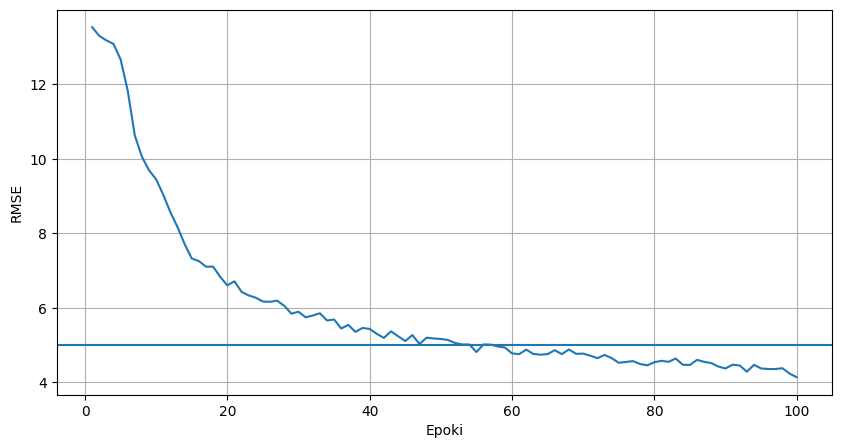

In [93]:
epochs = list(range(1, EPOCHS + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, rmse_hist)
plt.axhline(5.0)
plt.xlabel("Epoki")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

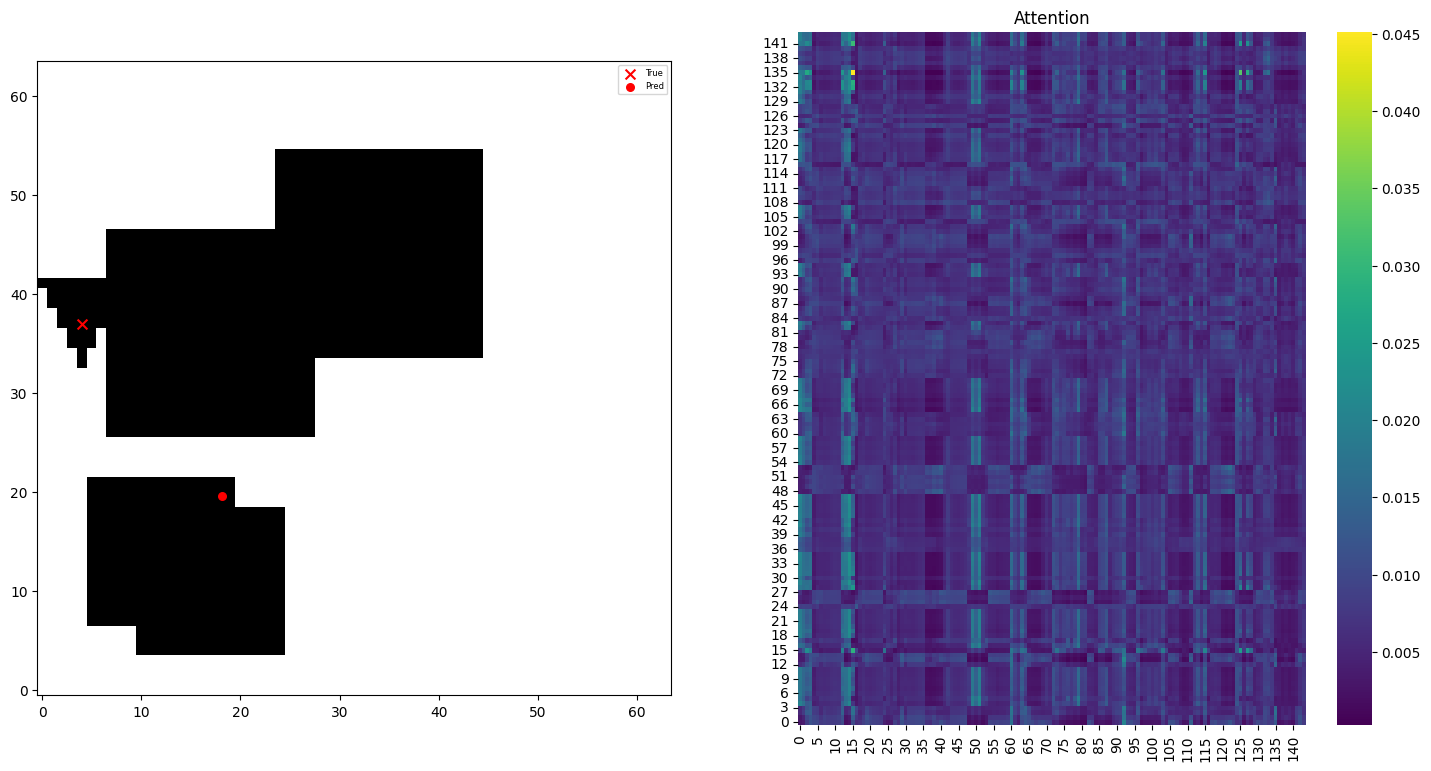

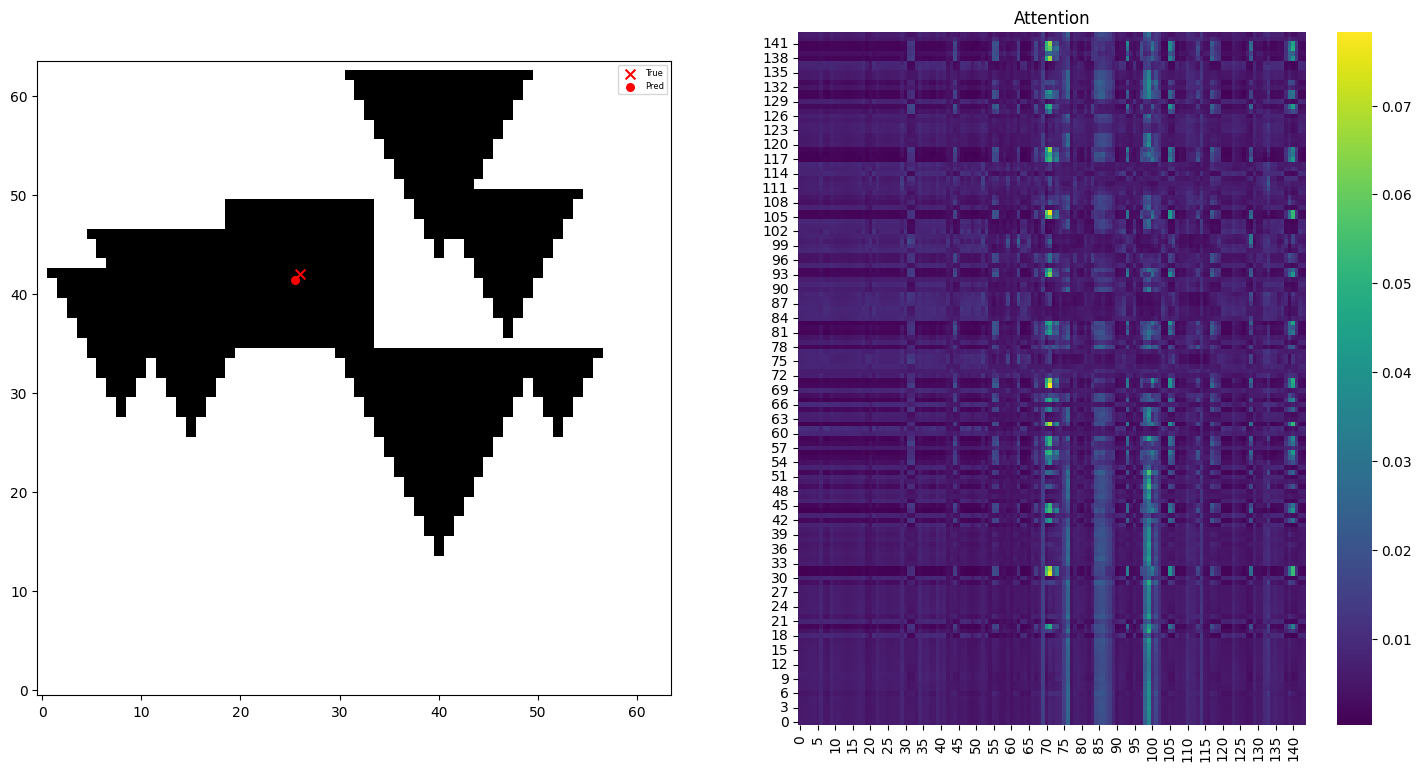

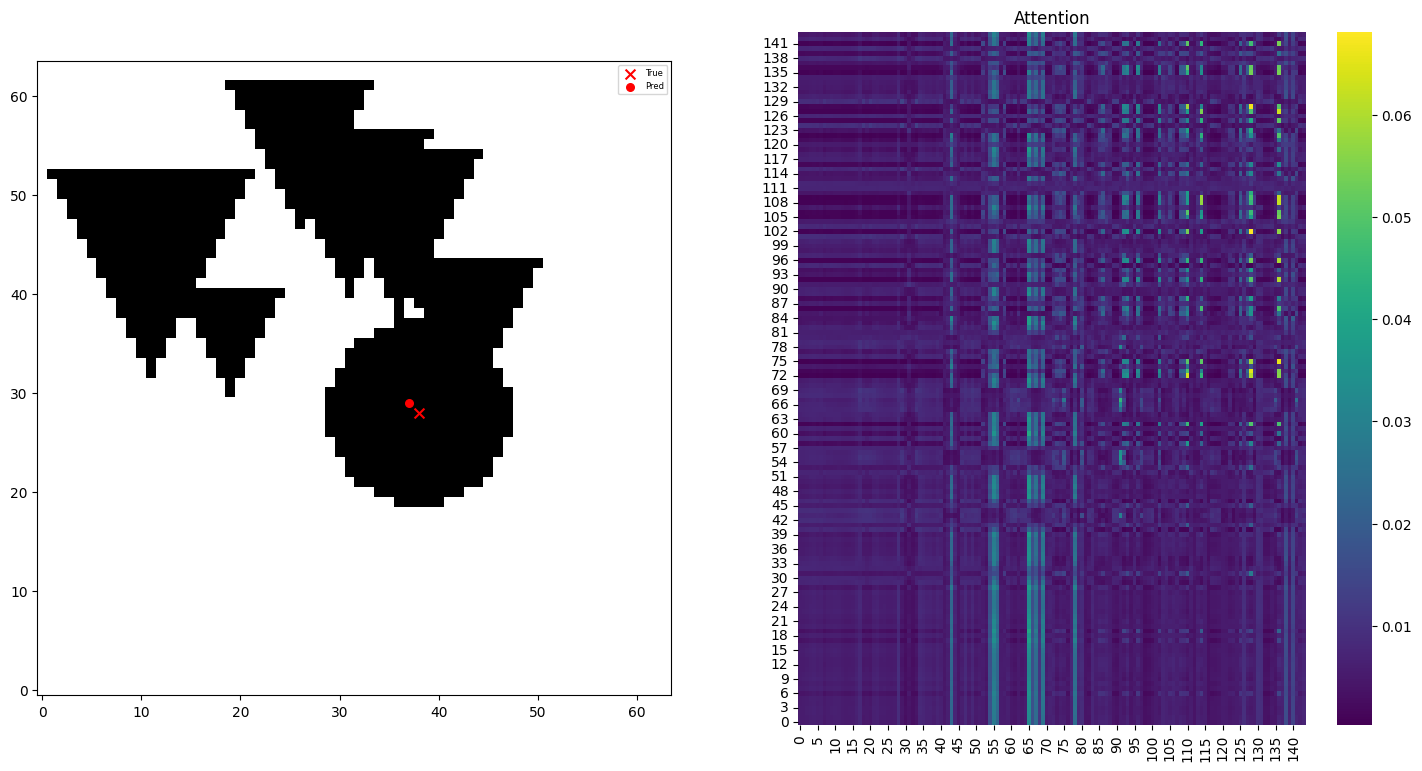

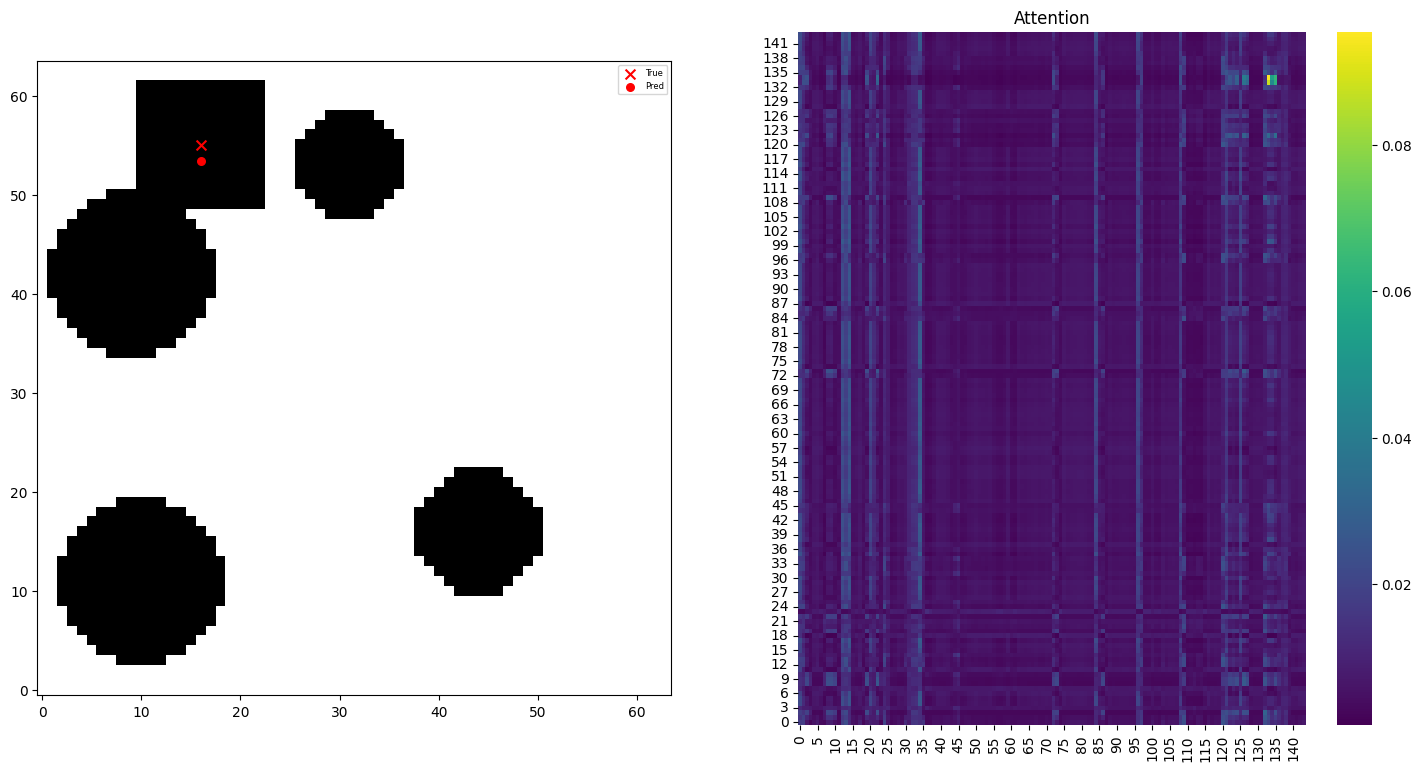

In [100]:
    model.eval()
    ds = OddXYDataset(4)
    ld = DataLoader(ds, batch_size=1)
    for i,(img,lbl) in enumerate(ld):
        fig,ax = plt.subplots(1,2,figsize=(18,9))
        pred_xy, attn = model(img.to(DEVICE), return_attn=True)
        attn_np = attn.detach().cpu().numpy().squeeze(0)
        img_np = img.squeeze().numpy()
        px,py = pred_xy.squeeze().detach().cpu().numpy()
        tx,ty = lbl.squeeze().numpy()
        rmse = math.sqrt((tx-px)**2+(ty-py)**2)

        ax[0].imshow(img_np,cmap="gray")
        ax[0].scatter(tx,ty,c="red",marker="x",s=50,label="True")
        ax[0].scatter(px,py,c="red",marker="o",s=30,label="Pred")
        ax[0].invert_yaxis()

        ax[0].legend(fontsize=6)

        sns.heatmap(attn_np, ax=ax[1], cmap="viridis")
        ax[1].invert_yaxis()
        ax[1].set_title("Attention")

Patrząc na heatmapy atencji możemy dojść do paru wniosków. Najjaśniejsze słupki na dobrze sklasyfikowanych przykładach wypadają tam, gdzie siatka patchy przecina inny kształt, czyli można wnioskować że większość tokenów zagląda do obszaru gdzie dzieje się coś innego. Po wielokrotnym uruchomieniu kodu można dojść do wnioski, że gdy zauważalnie źle model przewidział środek tam widać na macierz atencji, że model nie jest pewny gdzie szukać intruza - występuje dużo pasków podobnej jasności. Tam gdzie dobrze przewidział, zauważalny jest jeden pasek jaśniejszy. Zaskakującym według mnie może być pierwszy przykład na grafice, na którym model skrajnie źle dobrał środek, ale widać, na macierzy, że w pewnym sensie wykrył dziwny kształt.